In [12]:
# --- Imports ---
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow.data as data
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from keras import layers
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, f1_score, matthews_corrcoef, silhouette_score)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [13]:
# --- CIFAR-10 Loader ---
def load_batch(filepath):
    with open(filepath, 'rb') as f:
        batch = pickle.load(f, encoding='latin1')
    data = batch['data']
    labels = batch['labels']
    data = data.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    return data, labels

def load_cifar10_data(data_dir):
    x_train, y_train = [], []
    for i in range(1, 6):
        file = os.path.join(data_dir, f'data_batch_{i}')
        data, labels = load_batch(file)
        x_train.append(data)
        y_train.extend(labels)
    x_train = np.concatenate(x_train)
    y_train = np.array(y_train)
    x_test, y_test = load_batch(os.path.join(data_dir, 'test_batch'))
    return (x_train, y_train), (np.array(x_test), np.array(y_test))

# --- Load Data ---
data_dir = 'dataset/cifar-10-batches-py'
(x_train, y_train), (x_test, y_test) = load_cifar10_data(data_dir)
print(f"Train shape: {x_train.shape}, Labels: {y_train.shape}")
print(f"Test shape:  {x_test.shape}, Labels: {y_test.shape}")

x_train_flat = x_train.reshape((x_train.shape[0], -1))
x_test_flat = x_test.reshape((x_test.shape[0], -1))

x_train_flat = x_train_flat / 255.0
x_test_flat = x_test_flat / 255.0



Train shape: (50000, 32, 32, 3), Labels: (50000,)
Test shape:  (10000, 32, 32, 3), Labels: (10000,)


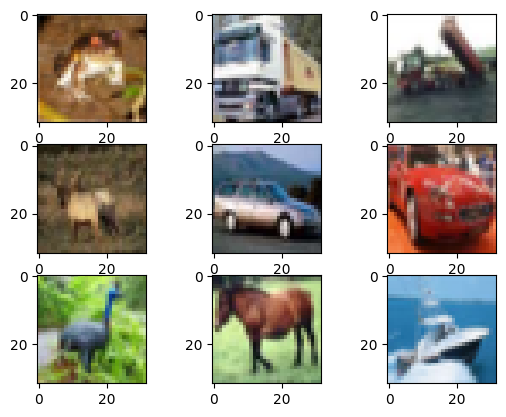

In [14]:
# To check the images
for i in range (0, 9):
  plt.subplot(330 + 1 + i)
  plt.imshow(x_train[i])
plt.show()

In [15]:
# augmentation (from that CHINESE site)
def advanced_data_augmentation(image):
    image = tf.image.random_crop(image, size=[28, 28, 3])      #rand crop to 28×28
    image = tf.image.resize(image, [32, 32])                  #get them back to 32x32
    image = tf.image.random_flip_left_right(image)            # rand left right flip
    # CHANGED: REDUCED ROTATION FROM 0-3 TO 0-1 (0° or 90° ONLY)
    k = tf.random.uniform(shape=[], minval=0, maxval=2, dtype=tf.int32)  # CHANGED maxval=4 to 2
    image = tf.image.rot90(image, k)
    image = tf.image.random_brightness(image, max_delta=0.2)  # CHANGED rand brightness 0.5 to 0.2
    image = tf.image.random_contrast(image, lower=0.5, upper=1.5)  # CHANGED rand contrast from 0.2&1.8 to 0.5&1.5
    return image.numpy()

# cutout
def cutout(image, mask_size=8):  # CHANGED 16 to 8
    h, w, _ = image.shape
    y = np.random.randint(h)
    x = np.random.randint(w)
    y1 = np.clip(y - mask_size // 2, 0, h)
    y2 = np.clip(y + mask_size // 2, 0, h)
    x1 = np.clip(x - mask_size // 2, 0, w)
    x2 = np.clip(x + mask_size // 2, 0, w)
    image[y1:y2, x1:x2] = 0
    return image

# REMOVED mixup

# flatten for rf and xgboost
y_train = y_train.flatten()
y_test = y_test.flatten()

# augm loop
aug_images = []
aug_labels = []


for img, lbl in zip(x_train, y_train):
    #advanced aug
    img_aug = advanced_data_augmentation(img)
    aug_images.append(img_aug)
    aug_labels.append(lbl)

    # cutout
    img_cut = cutout(img.copy())
    aug_images.append(img_cut)
    aug_labels.append(lbl)

#training data: combine orig + augm'd

all_imgs = np.concatenate([x_train, np.stack(aug_images)], axis=0)
all_lbls = np.concatenate([y_train, np.array(aug_labels)], axis=0)



In [16]:
# flatten for random forest & xgboost
n_samples = all_imgs.shape[0]
all_flat  = all_imgs.reshape(n_samples, -1)
x_test_flat = x_test.reshape(x_test.shape[0], -1)

# taking subset of data for training
subset_size = 100000
x_train_subset = all_flat[:subset_size]
y_train_subset = all_lbls[:subset_size]

Training Random Forest...
Random Forest Report:
               precision    recall  f1-score   support

           0       0.50      0.52      0.51      1000
           1       0.47      0.45      0.46      1000
           2       0.32      0.30      0.31      1000
           3       0.28      0.22      0.25      1000
           4       0.34      0.34      0.34      1000
           5       0.39      0.32      0.35      1000
           6       0.40      0.53      0.46      1000
           7       0.46      0.40      0.42      1000
           8       0.51      0.59      0.55      1000
           9       0.44      0.49      0.46      1000

    accuracy                           0.42     10000
   macro avg       0.41      0.42      0.41     10000
weighted avg       0.41      0.42      0.41     10000

RF Accuracy: 0.416
RF F1-Macro: 0.41129398122131555
RF MCC: 0.35158177224211595


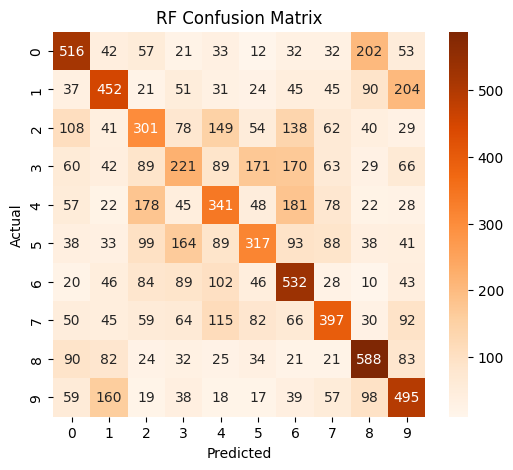

In [17]:
# --- Random Forest ---
print("Training Random Forest...")
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    n_jobs=-1,
    random_state=42
)
rf.fit(x_train_subset, y_train_subset)
rf_preds = rf.predict(x_test_flat)

# Metrics
print("Random Forest Report:\n", classification_report(y_test, rf_preds))
print("RF Accuracy:", accuracy_score(y_test, rf_preds))
print("RF F1-Macro:", f1_score(y_test, rf_preds, average='macro'))
print("RF MCC:", matthews_corrcoef(y_test, rf_preds))

# Confusion matrix
cm = confusion_matrix(y_test, rf_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges')
plt.title("RF Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Training XGBoost...
XGBoost Report:
               precision    recall  f1-score   support

           0       0.57      0.63      0.60      1000
           1       0.61      0.62      0.62      1000
           2       0.44      0.36      0.40      1000
           3       0.41      0.33      0.37      1000
           4       0.48      0.43      0.45      1000
           5       0.46      0.45      0.46      1000
           6       0.53      0.64      0.58      1000
           7       0.57      0.56      0.57      1000
           8       0.62      0.66      0.64      1000
           9       0.53      0.59      0.56      1000

    accuracy                           0.53     10000
   macro avg       0.52      0.53      0.52     10000
weighted avg       0.52      0.53      0.52     10000

XGB Accuracy: 0.5287
XGB F1-Macro: 0.5240046265151346
XGB MCC: 0.4767315705282265


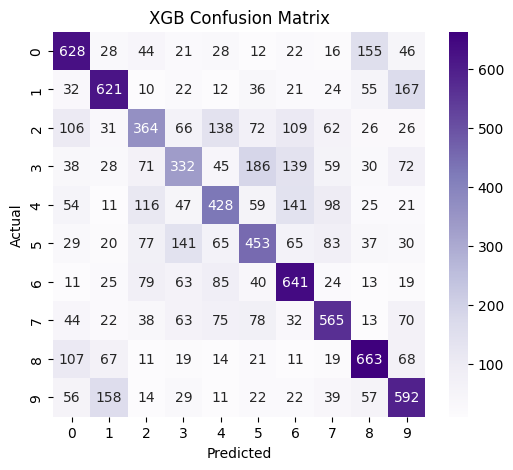

In [18]:
# --- XGBoost ---
print("Training XGBoost...")
xgb = XGBClassifier(
    n_estimators=100,
    max_depth=8,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method='gpu_hist',
    use_label_encoder=False,
    eval_metric='mlogloss',
    verbosity=0
)
xgb.fit(all_flat, all_lbls)
xgb_preds = xgb.predict(x_test_flat)

print("XGBoost Report:\n", classification_report(y_test, xgb_preds))
print("XGB Accuracy:", accuracy_score(y_test, xgb_preds))
print("XGB F1-Macro:", f1_score(y_test, xgb_preds, average='macro'))
print("XGB MCC:", matthews_corrcoef(y_test, xgb_preds))

cm = confusion_matrix(y_test, xgb_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples')
plt.title("XGB Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Training CNN...


c:\Users\alper\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.3320 - loss: 1.8221 - val_accuracy: 0.5133 - val_loss: 1.4098
Epoch 2/20
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.4950 - loss: 1.4256 - val_accuracy: 0.5577 - val_loss: 1.2797
Epoch 3/20
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.5341 - loss: 1.3218 - val_accuracy: 0.5857 - val_loss: 1.1950
Epoch 4/20
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.5583 - loss: 1.2603 - val_accuracy: 0.6054 - val_loss: 1.1514
Epoch 5/20
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.5686 - loss: 1.2267 - val_accuracy: 0.6023 - val_loss: 1.1653
Epoch 6/20
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.5841 - loss: 1.1863 - val_accuracy: 0.6140 - val_loss: 1.1198
Epoch 7/20
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.5913 - loss: 1.1616 - val_accuracy: 0.6199 - val_loss: 1.0950
Epoch 8/20
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.5992 - loss: 1

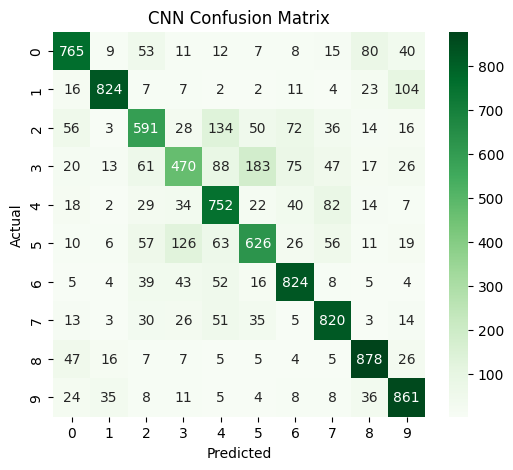

In [ ]:
# --- CNN Model ---
all_imgs = np.concatenate([x_train, np.stack(aug_images)], axis=0)
all_lbls = np.concatenate([y_train, np.array(aug_labels)], axis=0)

# normalize input images to [0,1]
x_train_norm = all_imgs.astype('float32') / 255.0
x_test_norm  = x_test.astype('float32')     / 255.0

# one‐hot on the combined training labels, and on the test labels
y_train_cat = to_categorical(all_lbls, 10)
y_test_cat  = to_categorical(y_test, 10)

print("Training CNN...")
y_train_cat = to_categorical(all_lbls, 10)
y_test_cat = to_categorical(y_test, 10)

cnn = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(32,32,3)),
    MaxPooling2D((2,2)),
    Dropout(0.25),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

cnn.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
cnn.fit(x_train_norm, y_train_cat, epochs=20, batch_size=64, validation_split=0.1, verbose=1)

cnn_preds = np.argmax(cnn.predict(x_test_norm), axis=1)
print("CNN Report:\n", classification_report(y_test, cnn_preds))
print("CNN Accuracy:", accuracy_score(y_test, cnn_preds))
print("CNN F1-Macro:", f1_score(y_test, cnn_preds, average='macro'))
print("CNN MCC:", matthews_corrcoef(y_test, cnn_preds))

cm = confusion_matrix(y_test, cnn_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title("CNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Training MLPClassifier...
Iteration 1, loss = 1.93688061
Iteration 2, loss = 1.70830358
Iteration 3, loss = 1.61473982
Iteration 4, loss = 1.55265929
Iteration 5, loss = 1.50612698
Iteration 6, loss = 1.47012626
Iteration 7, loss = 1.43455423
Iteration 8, loss = 1.40850132
Iteration 9, loss = 1.38847615
Iteration 10, loss = 1.35479951
Iteration 11, loss = 1.33427901
Iteration 12, loss = 1.30969550
Iteration 13, loss = 1.28572451
Iteration 14, loss = 1.26843417
Iteration 15, loss = 1.24672144
Iteration 16, loss = 1.23297555
Iteration 17, loss = 1.21855077
Iteration 18, loss = 1.19054060
Iteration 19, loss = 1.18442565
Iteration 20, loss = 1.16938090
Iteration 21, loss = 1.15021402
Iteration 22, loss = 1.13488384
Iteration 23, loss = 1.11439876
Iteration 24, loss = 1.10225945
Iteration 25, loss = 1.09687970
Iteration 26, loss = 1.07801096
Iteration 27, loss = 1.06465397
Iteration 28, loss = 1.05146124
Iteration 29, loss = 1.04541718
Iteration 30, loss = 1.02517748
Iteration 31, loss = 1.

c:\Users\alper\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP Report:
               precision    recall  f1-score   support

           0       0.42      0.64      0.51      1000
           1       0.57      0.59      0.58      1000
           2       0.63      0.11      0.19      1000
           3       0.31      0.15      0.21      1000
           4       0.64      0.05      0.09      1000
           5       0.26      0.62      0.37      1000
           6       0.80      0.13      0.23      1000
           7       0.47      0.62      0.53      1000
           8       0.58      0.65      0.61      1000
           9       0.39      0.69      0.50      1000

    accuracy                           0.43     10000
   macro avg       0.51      0.43      0.38     10000
weighted avg       0.51      0.43      0.38     10000

MLP Accuracy: 0.4263
MLP F1-Macro: 0.38268044790994027
MLP MCC: 0.37355678848967505


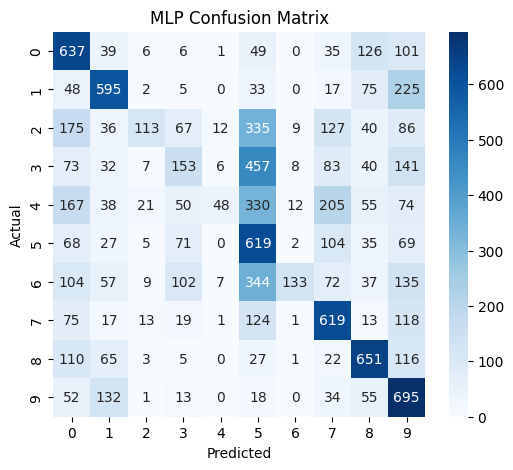

In [21]:
# --- MLP ---
print("Training MLPClassifier...")
mlp = MLPClassifier(
    hidden_layer_sizes=(512,256),
    activation='relu',
    solver='adam',
    alpha=1e-4,
    learning_rate_init=1e-3,
    max_iter=50,
    verbose=True,
    random_state=42
)
mlp.fit(x_train_flat, y_train)
mlp_preds = mlp.predict(x_test_flat)

print("MLP Report:\n", classification_report(y_test, mlp_preds))
print("MLP Accuracy:", accuracy_score(y_test, mlp_preds))
print("MLP F1-Macro:", f1_score(y_test, mlp_preds, average='macro'))
print("MLP MCC:", matthews_corrcoef(y_test, mlp_preds))

cm = confusion_matrix(y_test, mlp_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("MLP Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

,Model,Accuracy,F1-Macro,MCC
0,CNN,0.7411,0.737425,0.712886
1,XGBoost,0.5287,0.524005,0.476732
2,Random Forest,0.4160,0.411294,0.351582
3,MLP,0.4263,0.382680,0.373557


C:\Users\alper\AppData\Local\Temp\ipykernel_17648\1657580782.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results, x='Model', y='Accuracy', ax=axes[0], palette='Set2')
C:\Users\alper\AppData\Local\Temp\ipykernel_17648\1657580782.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
C:\Users\alper\AppData\Local\Temp\ipykernel_17648\1657580782.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results, x='Model', y='F1-Macro', ax=axes[1], palette='Set2')
C:\Users\alper\AppData\Local\Temp\ipykernel_17648\1657580782.py:38: UserWa

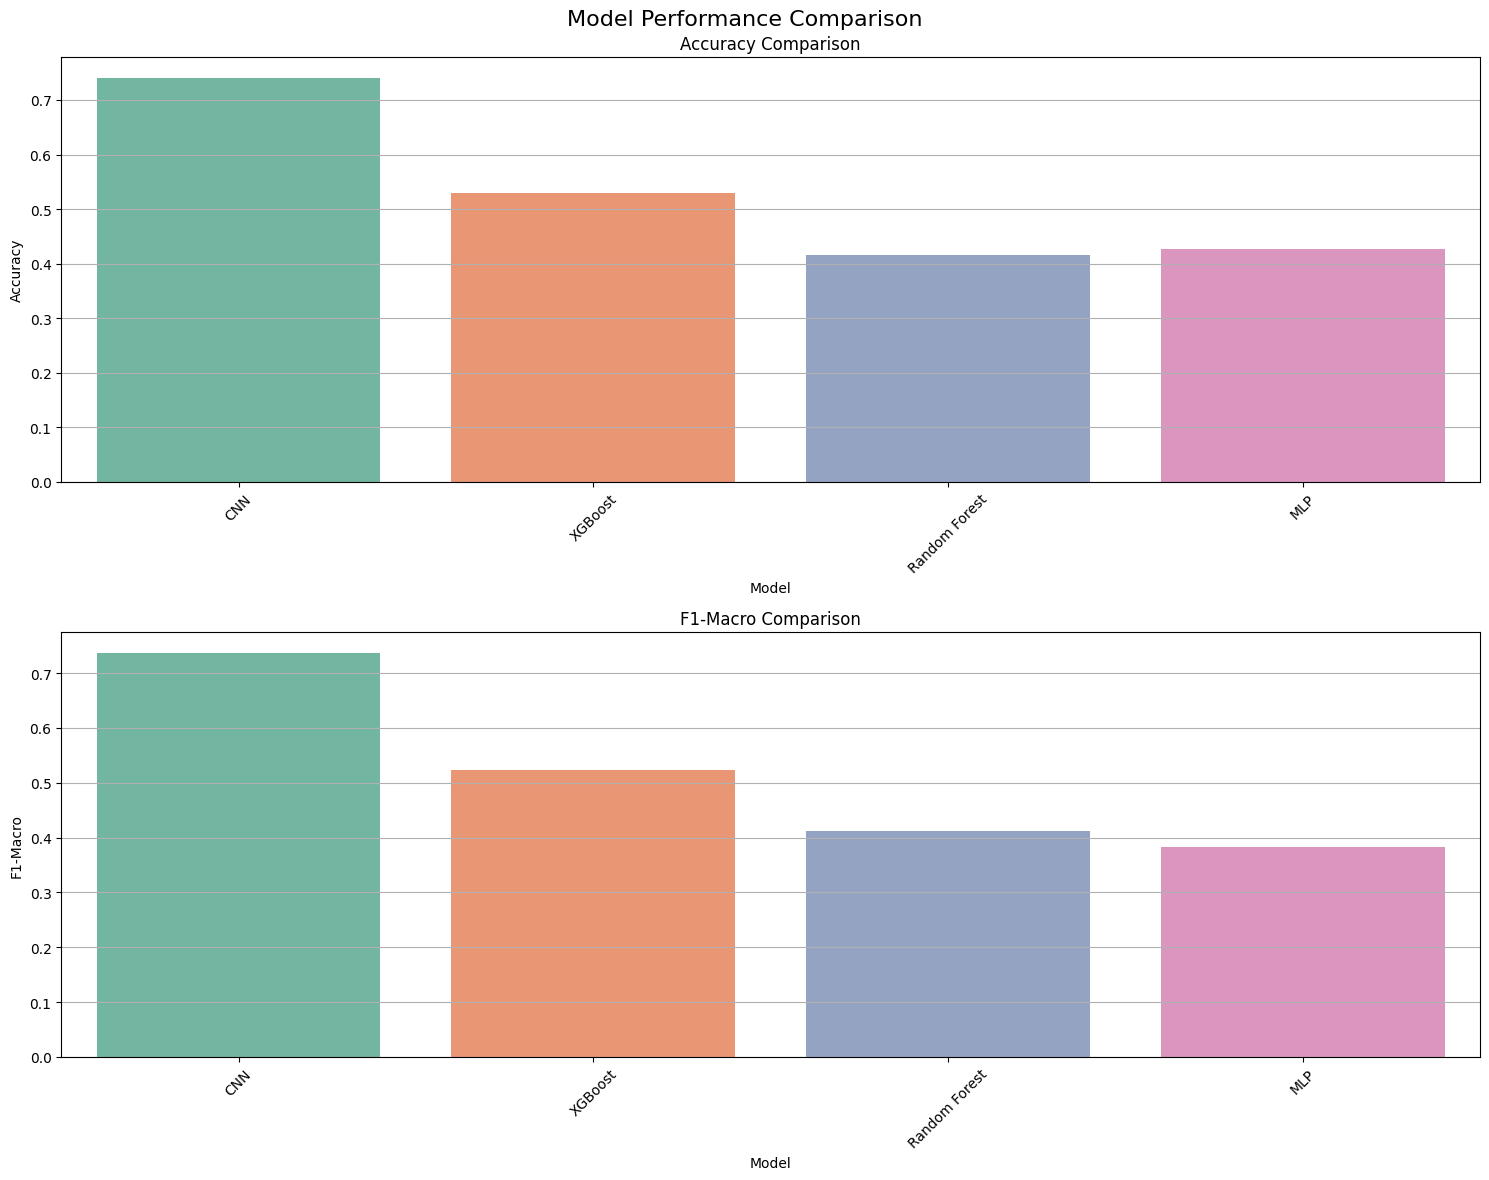

In [34]:
# --- Comparison ---
results = pd.DataFrame({
    'Model': ['CNN', 'XGBoost', 'Random Forest', 'MLP'],
    'Accuracy': [
        accuracy_score(y_test, cnn_preds),
        accuracy_score(y_test, xgb_preds),
        accuracy_score(y_test, rf_preds),
        accuracy_score(y_test, mlp_preds)
    ],
    'F1-Macro': [
        f1_score(y_test, cnn_preds, average='macro'),
        f1_score(y_test, xgb_preds, average='macro'),
        f1_score(y_test, rf_preds, average='macro'),
        f1_score(y_test, mlp_preds, average='macro')
    ],
    'MCC': [
        matthews_corrcoef(y_test, cnn_preds),
        matthews_corrcoef(y_test, xgb_preds),
        matthews_corrcoef(y_test, rf_preds),
        matthews_corrcoef(y_test, mlp_preds)
    ]
})
display(results)

# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(15, 12))
fig.suptitle('Model Performance Comparison', fontsize=16)

# Plot 1: Accuracy Comparison
sns.barplot(data=results, x='Model', y='Accuracy', ax=axes[0], palette='Set2')
axes[0].set_title('Accuracy Comparison')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
axes[0].grid(axis='y')

# Plot 2: F1-Macro Comparison
sns.barplot(data=results, x='Model', y='F1-Macro', ax=axes[1], palette='Set2')
axes[1].set_title('F1-Macro Comparison')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
axes[1].grid(axis='y')

plt.tight_layout()
plt.show()

Running KMeans clustering...
KMeans Silhouette Score: 0.065913918954911


True Label,0,1,2,3,4,5,6,7,8,9
Cluster,,,,,,,,,,
0,35,115,125,132,140,94,226,63,33,23
1,130,99,34,20,22,23,9,46,287,167
2,57,97,242,156,235,167,209,179,40,66
3,39,136,178,173,222,116,229,130,27,125
4,211,49,84,62,23,37,43,29,40,43
5,30,54,67,142,166,159,72,141,40,30
6,223,30,107,58,52,98,11,46,142,26
7,90,163,64,108,44,190,83,79,132,68
8,94,85,52,82,36,71,86,122,26,127


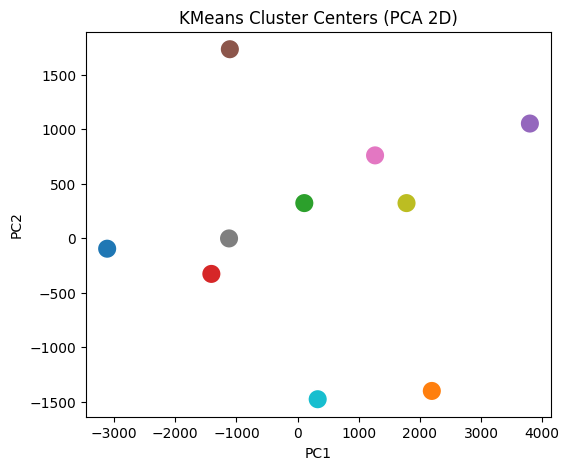

In [35]:
# --- KMeans Clustering ---
print("Running KMeans clustering...")
pca_k = PCA(n_components=50, random_state=42)
Xk = pca_k.fit_transform(x_test_flat)

kmeans = KMeans(n_clusters=10, random_state=42, n_init=10)
clusters = kmeans.fit_predict(Xk)

score = silhouette_score(Xk, clusters)
print("KMeans Silhouette Score:", score)

cont = pd.crosstab(clusters, y_test, rownames=['Cluster'], colnames=['True Label'])
display(cont)

# Cluster centers visualization in PCA 2D
pca2 = PCA(n_components=2, random_state=42)
X2 = pca2.fit_transform(x_test_flat)

centers_orig = pca_k.inverse_transform(kmeans.cluster_centers_)
centers2 = pca2.transform(centers_orig)

plt.figure(figsize=(6, 5))
sns.scatterplot(x=centers2[:, 0], y=centers2[:, 1],
                hue=list(range(10)), palette='tab10',
                s=200, legend=False)
plt.title("KMeans Cluster Centers (PCA 2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

,Model,Accuracy,F1-Macro,MCC
0,CNN,0.7411,0.737425,0.712886
1,XGBoost,0.5287,0.524005,0.476732
2,Random Forest,0.4160,0.411294,0.351582
3,MLP,0.4263,0.382680,0.373557


<Figure size 800x500 with 0 Axes>

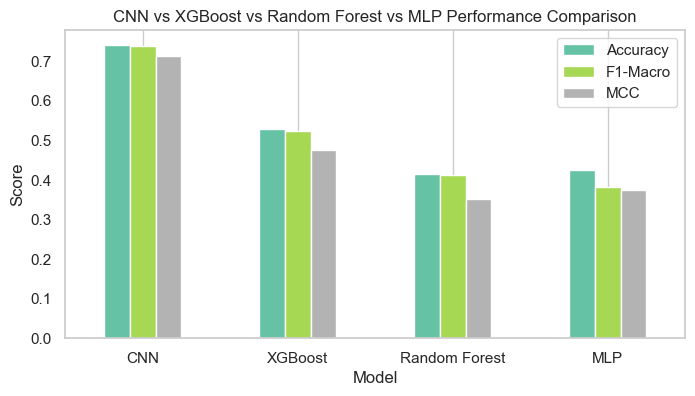

In [50]:
# --- Accuracy, F1-Macro, MCC Comparison ---
cnn_acc = accuracy_score(y_test, cnn_preds)
xgb_acc = accuracy_score(y_test, xgb_preds)
rf_acc = accuracy_score(y_test, rf_preds)
mlp_acc = accuracy_score(y_test, mlp_preds)

cnn_f1 = f1_score(y_test, cnn_preds, average='macro')
xgb_f1 = f1_score(y_test, xgb_preds, average='macro')
rf_f1 = f1_score(y_test, rf_preds, average='macro')
mlp_f1 = f1_score(y_test, mlp_preds, average='macro')

cnn_mcc = matthews_corrcoef(y_test, cnn_preds)
xgb_mcc = matthews_corrcoef(y_test, xgb_preds)
rf_mcc = matthews_corrcoef(y_test, rf_preds)
mlp_mcc = matthews_corrcoef(y_test, mlp_preds)

results = pd.DataFrame({
    'Model': ['CNN', 'XGBoost', 'Random Forest', 'MLP'],
    'Accuracy': [cnn_acc, xgb_acc, rf_acc, mlp_acc],
    'F1-Macro': [cnn_f1, xgb_f1, rf_f1, mlp_f1],
    'MCC': [cnn_mcc, xgb_mcc, rf_mcc, mlp_mcc]
})
display(results)

plt.figure(figsize=(8,5))
results.set_index('Model')[['Accuracy','F1-Macro','MCC']].plot(
    kind='bar', rot=0, figsize=(8,4), colormap='Set2'
)
plt.title("CNN vs XGBoost vs Random Forest vs MLP Performance Comparison")
plt.ylabel("Score")
plt.grid(axis='y')
plt.show()


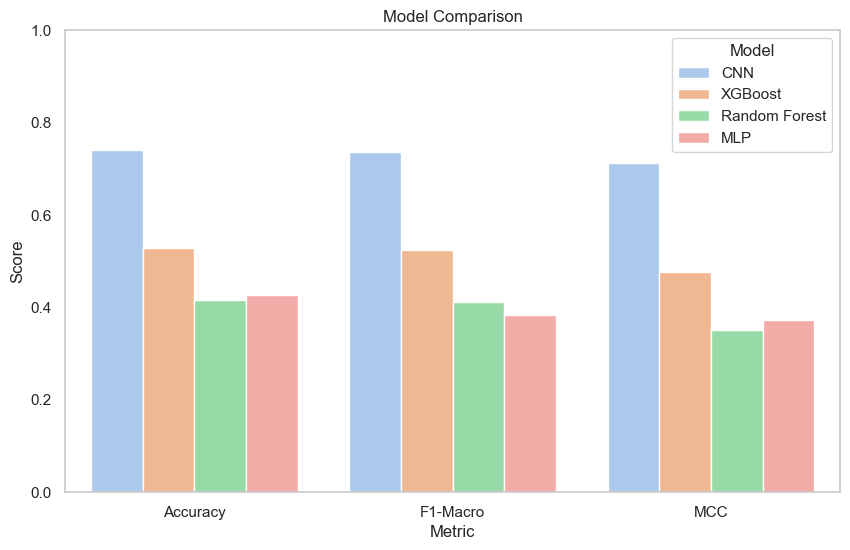

In [51]:
metrics_data = {
    'Model': ['CNN', 'XGBoost', 'Random Forest', 'MLP'] * 3,
    'Metric': ['Accuracy'] * 4 + ['F1-Macro'] * 4 + ['MCC'] * 4,
    'Score': [
        cnn_acc, xgb_acc,rf_acc,mlp_acc,   # Accuracy 
        cnn_f1, xgb_f1,rf_f1,mlp_f1,       # F1 
        cnn_mcc, xgb_mcc,rf_mcc,mlp_mcc    # MCC 
    ]
}

df_plot = pd.DataFrame(metrics_data)

# Seaborn barplot
plt.figure(figsize=(10,6))
sns.barplot(data=df_plot, x='Metric', y='Score', hue='Model', palette='pastel')
plt.title("Model Comparison")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.legend(title="Model")
plt.show()


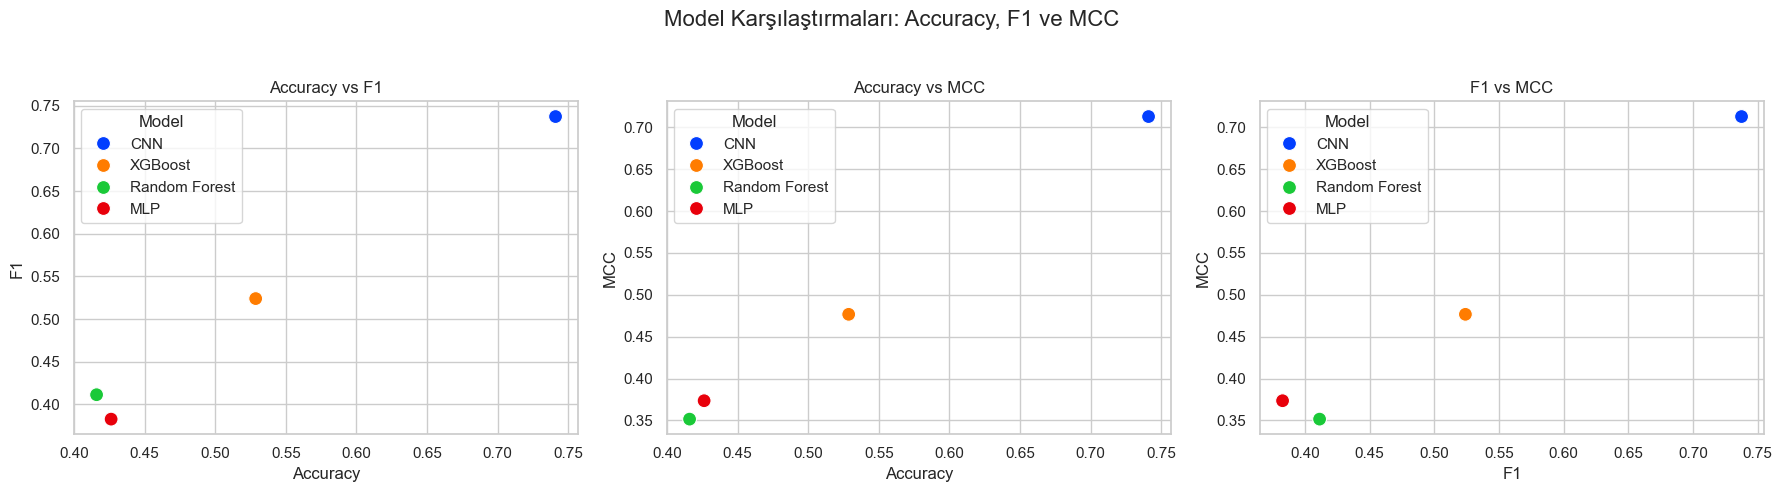

In [52]:
# --- Accuracy, F1-Macro, MCC Comparison on Every Model with Each Other---
data = {
    'Model': ['CNN', 'XGBoost', 'Random Forest', 'MLP'],
    'Accuracy': [cnn_acc, xgb_acc, rf_acc, mlp_acc],
    'F1': [cnn_f1, xgb_f1, rf_f1, mlp_f1],
    'MCC': [cnn_mcc, xgb_mcc, rf_mcc, mlp_mcc]
}

df = pd.DataFrame(data)
metrics = ['Accuracy', 'F1', 'MCC']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

pairs = [('Accuracy', 'F1'), ('Accuracy', 'MCC'), ('F1', 'MCC')]
for ax, (x, y) in zip(axes, pairs):
    sns.scatterplot(data=df, x=x, y=y, hue="Model", palette="bright", s=100, ax=ax)
    ax.set_title(f'{x} vs {y}')
    ax.grid(True)

plt.suptitle("Model Karşılaştırmaları: Accuracy, F1 ve MCC", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()